In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import keras
if keras.backend.backend() == "torch":
    import torch
    print("Use torch backend")
    torch.autograd.set_grad_enabled(False)
import sys
current_dir = globals()['_dh'][0]
sys.path.append(os.path.join(current_dir, "../"))
import bayesflow as bf

Use torch backend


In [2]:
from evaluation_experiment_1 import evaluate_loss
from diagnostics import plot_recovery
import pickle
import sys
from custom_simulators import ParameterMask, RandomNumObs
from design_networks import RandomDesign, DADMulti6, DADSimple, DADMulti7, DADMulti8, DADMulti9, DADMulti10
from custom_dataset import DataSet
from experiment_1 import StudentT, PriorPolynomialReg
from design_loss import NestedMonteCarlo
import pickle
from functools import partial
#import matplotlib.pyplot as plt
#from matplotlib.gridspec import GridSpec

In [3]:
path = "results/joint_t_dad10"

In [4]:
with open(os.path.join(path, 'arguments.pkl'), 'rb') as file:
    args_dict = pickle.load(file)

In [5]:
# Fixed settings
n_history = 1
T = 10
bf_summary_dim = 10
bf_batch_size = 128
design_size = 1

summary_network = bf.networks.DeepSet(summary_dim =  10)
inference_network = bf.networks.CouplingFlow(depth = 5)
data_adapter = bf.ContinuousApproximator.build_data_adapter(
        inference_variables = ["params"],
        inference_conditions = ["masks", "n_obs"],
        summary_variables = ["outcomes", "designs"],
        transforms = None
    )

approximator = bf.ContinuousApproximator(
            inference_network = inference_network,
            summary_network = summary_network,
            data_adapter = data_adapter
    )

if args_dict["include_intercept"]:
        possible_masks = torch.tril(torch.ones((args_dict["degree"] + args_dict["include_intercept"], args_dict["degree"] + args_dict["include_intercept"])))[1:, :]
else:
    possible_masks = torch.tril(torch.ones((args_dict["degree"], args_dict["degree"])))
if args_dict["single_model"]:
    possible_masks = possible_masks[-1:, :] # only one model

mask_sampler = ParameterMask(possible_masks = torch.tensor(possible_masks))
prior_sampler = PriorPolynomialReg()
random_num_obs_1 = RandomNumObs(min_obs = 1, max_obs = 10)
random_num_obs_2 = RandomNumObs(min_obs = 0, max_obs = 10)
random_design_generator = RandomDesign(design_size = design_size)

sim_vars = {"degree": args_dict["degree"], "include_intercept": args_dict["include_intercept"], "noise_size": 1.0}
model = StudentT

model_1 = model(mask_sampler,
                prior_sampler = prior_sampler,
                tau_sampler = random_num_obs_1,
                design_generator = random_design_generator,
                sim_vars = sim_vars)

if args_dict["single_model"]:
        design_net = DADSimple(design_size = 1,
                               y_dim = 1,
                               embedding_dim = args_dict["dad_summary_dim"],
                               batch_size = args_dict["dad_positive_samples"])
else:
    design_net = DADMulti10(design_size = 1,
                           y_dim = 1,
                           embedding_dim = args_dict["dad_summary_dim"],
                           context_dim = args_dict["include_intercept"] + args_dict["degree"],
                           batch_size = args_dict["dad_positive_samples"],
                           T = T)

model_2 = model(mask_sampler = mask_sampler,
                          prior_sampler = prior_sampler,
                          tau_sampler = random_num_obs_2,
                          design_generator = design_net,
                          sim_vars = sim_vars)
model_3 = model(mask_sampler = mask_sampler,
                          prior_sampler = prior_sampler,
                          tau_sampler = random_num_obs_1,
                          design_generator = design_net,
                          sim_vars = sim_vars)
dataset = DataSet(batch_size = bf_batch_size, 
                  joint_model_1 = model_1,
                  joint_model_2 = model_2,
                  joint_model_3 = model_3,
                  data_adapter = data_adapter)

dataset.set_stage(1)
# approximator.build_from_data(dataset[0])
# model_2.design_generator.load_state_dict(torch.load(os.path.join(path, "design_network_stage_1.pt"))["model_state_dict"])
model_2.design_generator.load_state_dict(torch.load(os.path.join(path, "design_network_stage_2.pt"))["model_state_dict"])
# approximator.load_weights(os.path.join(path, "approximator_stage_2.weights.h5"))
# approximator.load_weights(os.path.join(path, "approximator_stage_1.weights.h5"))

<All keys matched successfully>

### Loss curve

In [6]:
f = evaluate_loss(path)

KeyError: 'loss'

### Plot recovery

In [25]:
n_sims = 2000; n_samples = 100
if args_dict["single_model"]:
    test_sims = model_2.sample(n_sims, tau = T) # for single model
else:
    mask = [1., 1., 1., 1.] # for multiple models
    test_sims = model_2.sample(n_sims, masks = torch.tensor(mask), T = T) 
post_samples = approximator.sample(num_samples = n_samples, conditions = test_sims)["params"]

TypeError: ContinuousApproximator._sample() got an unexpected keyword argument 'inference_variables'

In [51]:
n_sims = 2000; n_samples = 100
if args_dict["single_model"]:
    test_sims = model_1.sample(n_sims, tau = T) # for single model

else:
    mask = [1., 1., 0., 0.] # for multiple models
    test_sims = model_1.sample(n_sims, masks = torch.tensor(mask), T = T) 
true_param = test_sims["params"]
del test_sims["params"]
post_samples = approximator.sample(num_samples = n_samples, conditions = test_sims)["params"]

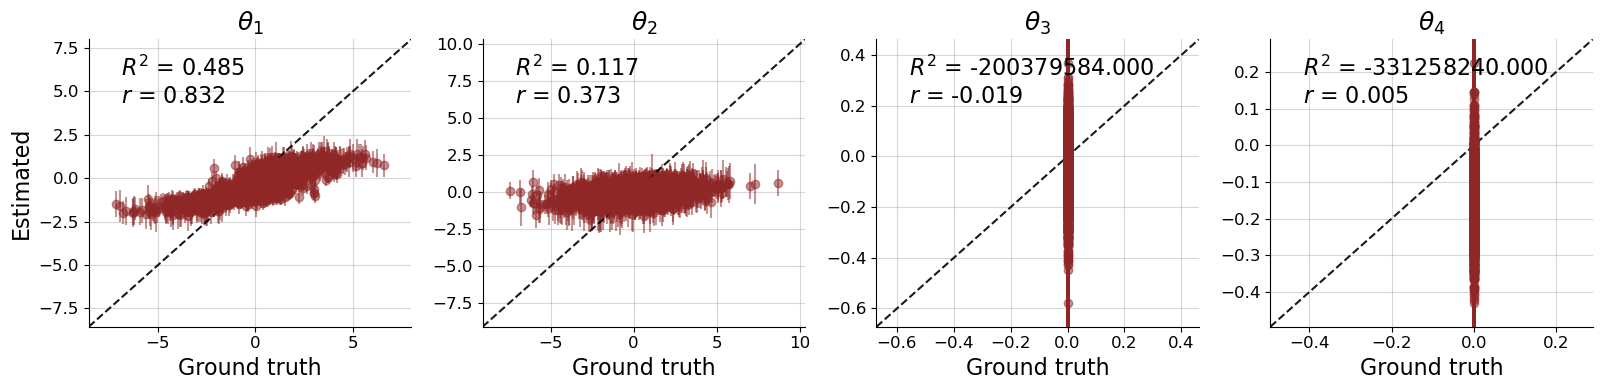

In [52]:
f = plot_recovery(post_samples, true_param)

### Mutual Information

In [8]:
mask = [1., 1., 1., 1.] # only used for multiple models
if args_dict["single_model"]:
    model_2_single = model_2
    model_1_single = model_1
else:
    mask_sampler_single = ParameterMask(possible_masks = torch.tensor([mask]))
    model_2_single = model(mask_sampler = mask_sampler_single,
                                     prior_sampler = model_2.prior_sampler,
                                     tau_sampler = model_2.tau_sampler,
                                     design_generator = model_2.design_generator,
                                     sim_vars = model_2.sim_vars)
    model_1_single = model(mask_sampler = mask_sampler_single,
                                     prior_sampler = model_1.prior_sampler,
                                     tau_sampler = model_1.tau_sampler,
                                     design_generator = model_1.design_generator,
                                     sim_vars = model_1.sim_vars)

eval_lower_dad = NestedMonteCarlo(
    approximator = approximator,
    joint_model = model_2_single,
    batch_size = 1000,
    num_negative_samples = 10000,
    lower_bound = True
)
eval_lower_random = NestedMonteCarlo(
    approximator = approximator,
    joint_model = model_1_single,
    batch_size = 1000,
    num_negative_samples = 10000,
    lower_bound = True
)
print("DAD lower bound: ", eval_lower_dad.estimate())
print("Random lower bound: ", eval_lower_random.estimate())

DAD lower bound:  3.942124605178833
Random lower bound:  2.9530270099639893


name_of_model | DAD lower bound | Random lower bound

Multi model

M1 | 1.46 | 1.35

M2 | 2.14 | 1.90

M3 | 2.13 | 1.91

Multi model with Context in embed

M1 | 2.07 | 1.45

M2 | 2.59 | 1.52

M3 | 2.86 | 1.73


Single model

M1 | 2.28 | 1.43

M2 | 2.62 | 1.49

M3 | 2.83 | 1.68

--------

NEW: with posterior

Multi Posterior | Random | Single Model Prior | Multi Prior 

M1 | 3.15 | 2.41

M2 | 3.79 | 2.75

M3 | 4.07 | 2.93